In [ ]:
!pip install -r requirements.txt

In [ ]:
from accelerate import Accelerator

In [ ]:
import os
import torch
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    AutoConfig,
    BitsAndBytesConfig,
)
import time
import json
import matplotlib.pyplot as plt
import seaborn as sns
import wandb

In [ ]:
os.environ["CUDA_VISIBLE_DEVICES"]="0"

### 1. Define Prompt Template

**Prompt template:**

\<s>[INST] \<\<SYS>>

{{system message}}

\<\</SYS>>

{{message/input}} [/INST] {{answer}} \</s>

<hr>



#### 1.2 Sample training prompt : Context + Speaker
```
<s>[INST]
"conversation": [
{
"utterance_ID": 1,
"text": "I am sorry it did not work out .",
"speaker": "Monica"
},
{
"utterance_ID": 2,
"text": "What not work out ? I am seeing her again on Thursday .",
"speaker": "Chandler"
},
{
"utterance_ID": 3,
"text": "Did not you listen to the story ?",
"speaker": "Chandler"
},
{
"utterance_ID": 4,
"text": "Did not you listen to the story ?",
"speaker": "Monica"
},
{
"utterance_ID": 5,
"text": "I mean , this is twisted ! How could you get involved with a woman like this ?",
"speaker": "Monica"
},
{
"utterance_ID": 6,
"text": "Well , you know , I had some trouble with it at first too , but the way I look at it is , I get all the good stuff : all the fun , all the talking , all the sex ; and none of the responsibility .",
"speaker": "Chandler"
},
{
"utterance_ID": 7,
"text": "This is every guy fantasy !",
"speaker": "Chandler"
},
{
"utterance_ID": 8,
"text": "Oh , yeah . That is not true . Ross , is this your fantasy ?",
"speaker": "Phoebe"
},
{
"utterance_ID": 9,
"text": "No , of course not .",
"speaker": "Ross"
},
{
"utterance_ID": 10,
"text": "Yeah . Yeah , it is .",
"speaker": "Ross"
},
{
"utterance_ID": 11,
"text": "So you guys do not mind going out with someone else who is going out with someone else ?",
"speaker": "Monica"
},
{
"utterance_ID": 12,
"text": "I could not do it .",
"speaker": "Joey"
},
{
"utterance_ID": 13,
"text": "Good for you , Joey .",
"speaker": "Monica"
},
{
"utterance_ID": 14,
"text": "When I am with a woman , I need to know that I am going out with more people than she is .",
"speaker": "Joey"
}
]
Analyze the conversation and identify the emotion label out of the 7 labels: joy, anger, disgust, fear, sadness, surprise, neutral for utterance 5.
Output in format:
utterance_id :: emotion_label
[/INST]
utterance_5 :: disgust
</s>
```

### 2. Preprocess the Input

In [ ]:
def get_prompt(sample_data_point, speaker=False, video=False, audio=False):
	if speaker and video and audio:
		instruction = """Identify the emotion label out of the 7 labels: joy, anger, disgust, fear, sadness, surprise, neutral for utterance {}. The video_captions for each utterance describe the video corresponding to the text and the audio captions describe the audio. No explanation.
Output in format:
utterance_id :: emotion_label
""".format(sample_data_point["utterance_id"])
	elif speaker and video:
		instruction = """Identify the emotion label out of the 7 labels: joy, anger, disgust, fear, sadness, surprise, neutral for utterance {}. The video_captions for each utterance describe the video corresponding to the text. No explanation.
Output in format:
utterance_id :: emotion_label
""".format(sample_data_point["utterance_id"])
	elif speaker:
		instruction = """Identify the emotion label out of the 7 labels: joy, anger, disgust, fear, sadness, surprise, neutral for utterance {}. No explanation.
Output in format:
utterance_id :: emotion_label
""".format(sample_data_point["utterance_id"])
	else:
		instruction = """Identify the emotion label out of the 7 labels: joy, anger, disgust, fear, sadness, surprise, neutral for utterance {}. No explanation.
Output in format:
utterance_id :: emotion_label
""".format(sample_data_point["utterance_id"])

	return f"""<s>[INST]
{instruction}
{sample_data_point['conversation']}
[/INST]
""", f"""utterance_{sample_data_point["utterance_id"]} :: {sample_data_point['emotion_label']}
</s>
"""


In [ ]:
def get_formatted_conversation(data_sample, speaker=False, video=False, audio=False):
    conversation_str = '"conversation": [\n'
    for utt in data_sample["conversation"]:
        # conversation_str
        if speaker and video and audio:
            conversation_str += "{{\n\"utterance_ID\": {}\n\"text\": {}\n\"speaker\": {}\n\"video_captions\": [".format(utt["utterance_ID"], utt["text"], utt["speaker"])
            conversation_str += ' , '.join(utt["video_captions"])
            conversation_str += "]\n\"audio_captions\": ["
            conversation_str += ' , '.join(utt["audio_captions"])
            conversation_str += "]\n}}\n"
        elif speaker and video:
            conversation_str += "{{\n\"utterance_ID\": {}\n\"text\": {}\n\"speaker\": {}\n\"video_captions\": [".format(utt["utterance_ID"], utt["text"], utt["speaker"])
            conversation_str += ' , '.join(utt["video_captions"])
            conversation_str += "]\n}}\n"
        elif speaker:
            conversation_str += "{{\n\"utterance_ID\": {}\n\"text\": {}\n\"speaker\": {}\n}}\n".format(utt["utterance_ID"], utt["text"], utt["speaker"])
        else:
            conversation_str += "{{\n\"utterance_ID\": {}\n\"text\": {}\n}}\n".format(utt["utterance_ID"], utt["text"])
    return conversation_str

In [ ]:
def form_input(data_sample, utt_id, speaker=False, video=False, audio=False):
    conversation_str = get_formatted_conversation(data_sample, speaker, video, audio)
    emotions_str = data_sample["conversation"][utt_id]["emotion"]
    sample_data_point = {} # has utterance_id, conversation, emotion_label

    sample_data_point["utterance_id"] = utt_id+1
    sample_data_point["conversation"] = conversation_str
    sample_data_point["emotion_label"] = emotions_str
    sample_data_point["conversation_id"] = data_sample["conversation_ID"]
    return sample_data_point


In [ ]:
def generate_inst_for_each_utt_of_conv(data_point, speaker=False, video=False, audio=False):
    num_utt = len(data_point["conversation"])
    list_output_objects = []
    for i in range(num_utt):
        sample_data_point = form_input(data_point, i, speaker, video, audio)
        inst, out = get_prompt(sample_data_point, speaker, video, audio)
        obj = {
            "instruction": inst,
            "out": out,
            "text": inst + out
        }
        list_output_objects.append(obj)
    return list_output_objects

In [ ]:
def process_dataset(data, speaker=False, video=False, audio=False):
    flattened_list = [element for sublist in map(lambda x: generate_inst_for_each_utt_of_conv(x, speaker, video, audio), data) for element in sublist]
    ds = {}
    ds["instruction"] = [sample["instruction"] for sample in flattened_list]
    ds["out"] = [sample["out"] for sample in flattened_list]
    ds["text"] = [sample["text"] for sample in flattened_list]
    return ds

In [ ]:
from generate_input import *

In [ ]:
# Params
class Config:
    def __init__(self) -> None:
        self.seed = 42
        self.speaker = True
        self.video = False
        self.audio = False

In [ ]:
config = Config()
test_file, train_file, val_file = generate_input(config)

with open(train_file, 'r') as f:
    train_data = json.load(f)
with open(val_file, 'r') as f:
    val_data = json.load(f)
with open(test_file, 'r') as f:
    test_data = json.load(f)

Number of conversations in dataset: 138
Number of conversations in dataset: 1112
Number of conversations in dataset: 124


In [ ]:
# Form datasets from data
train_dataset = process_dataset(train_data, speaker=True)
val_dataset = process_dataset(val_data, speaker=True)
test_dataset = process_dataset(test_data, speaker=True)

In [ ]:
from datasets import Dataset
train_dataset = Dataset.from_dict(train_dataset)
val_dataset = Dataset.from_dict(val_dataset)
test_dataset = Dataset.from_dict(test_dataset)

In [ ]:
print(train_dataset["text"][0])

<s>[INST]
Identify the emotion label out of the 7 labels: joy, anger, disgust, fear, sadness, surprise, neutral for utterance 1. No explanation.
Output in format:
utterance_id :: emotion_label

"conversation": [
{
"utterance_ID": 1
"text": Really ? You would ... you would do that for me ? !
"speaker": Joey
}
{
"utterance_ID": 2
"text": Yeah !
"speaker": Ross
}
{
"utterance_ID": 3
"text": Thanks !
"speaker": Joey
}
{
"utterance_ID": 4
"text": All right , we will start off slow . The only thing you have to do tonight is come up with the name of your main character .
"speaker": Ross
}
{
"utterance_ID": 5
"text": Done !
"speaker": Joey
}
{
"utterance_ID": 6
"text": And it can not be Joey .
"speaker": Ross
}
{
"utterance_ID": 7
"text": It is not .
"speaker": Joey
}
{
"utterance_ID": 8
"text": Or Joseph .
"speaker": Ross
}
{
"utterance_ID": 9
"text": Oh .
"speaker": Joey
}

[/INST]
utterance_1 :: surprise
</s>



### 3. Fine-tune Llama 2 using QLoRA
[QLoRA: Efficient Finetuning of Quantized LLMs](https://arxiv.org/abs/2305.14314)

In [ ]:
# Can't Load the model on a 4GB or even 16GB GPU, so use accelerate for automatically creating device map
import accelerate

In [ ]:
model_id = "meta-llama/Llama-2-13b-chat-hf"

In [ ]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    A token is already saved on your machine. Run `huggingface-cli whoami` to get more information or `huggingface-cli logout` if you want to log out.
    Setting a new token will erase the existing one.
    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Token: 
Add token as git credential? (Y/n) y
Token is valid (permission: read).
Cannot authenticate through git-creden

In [ ]:
model_config = AutoConfig.from_pretrained(model_id)

with accelerate.init_empty_weights():
    fake_model = AutoModelForCausalLM.from_config(model_config)

device_map=accelerate.infer_auto_device_map(fake_model, max_memory={0: "5GiB", "cpu": "10GiB"}) #
print(json.dumps(device_map, indent=4))

{
    "model.embed_tokens": 0,
    "model.layers.0": 0,
    "model.layers.1": 0,
    "model.layers.2": 0,
    "model.layers.3.self_attn.q_proj": 0,
    "model.layers.3.self_attn.k_proj": 0,
    "model.layers.3.self_attn.v_proj": "cpu",
    "model.layers.3.self_attn.o_proj": "cpu",
    "model.layers.3.self_attn.rotary_emb": "cpu",
    "model.layers.3.mlp": "cpu",
    "model.layers.3.input_layernorm": "cpu",
    "model.layers.3.post_attention_layernorm": "cpu",
    "model.layers.4": "cpu",
    "model.layers.5": "cpu",
    "model.layers.6": "cpu",
    "model.layers.7": "cpu",
    "model.layers.8": "cpu",
    "model.layers.9": "cpu",
    "model.layers.10": "cpu",
    "model.layers.11.self_attn.q_proj": "cpu",
    "model.layers.11.self_attn.k_proj": "disk",
    "model.layers.11.self_attn.v_proj": "disk",
    "model.layers.11.self_attn.o_proj": "disk",
    "model.layers.11.self_attn.rotary_emb": "disk",
    "model.layers.11.mlp": "disk",
    "model.layers.11.input_layernorm": "disk",
    "mo

In [ ]:
# Use 4-bit quantized version of model, wgts and activations -> 4 bits
compute_dtype = getattr(torch, "float16")
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4", # 4-bit quantized noraml float
    bnb_compute_dtype=compute_dtype,
    llm_int8_enable_fp32_cpu_offload=True,
)

In [ ]:
model = AutoModelForCausalLM.from_pretrained(model_id,
                                             quantization_config=bnb_config,
                                             device_map={"": Accelerator().local_process_index},
                                             offload_folder="/tmp/.offload",
                                             low_cpu_mem_usage=True,
                                             torch_dtype=torch.float16,
                                             )
tokenizer = AutoTokenizer.from_pretrained(model_id)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_size = "right"

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

#### **Zero Shot Inference**

In [ ]:
index = 0
prompt = train_dataset["instruction"][index]
print(prompt)

inputs = tokenizer(prompt, return_tensors='pt')
output = tokenizer.decode(
    model.generate(
        input_ids=inputs["input_ids"],
    )[0],
    skip_special_tokens=True
)

dash_line = '-'.join('' for x in range(100))
print(dash_line)
print(f'INPUT PROMPT:\n{prompt}')
print(dash_line)
print(f'BASELINE OUTPUT:\n{train_dataset["out"][index]}')
print(dash_line)
print(f'MODEL OUTPUT (ZERO SHOT):\n{output}')
print(dash_line)

<s>[INST]
Identify the emotion label out of the 7 labels: joy, anger, disgust, fear, sadness, surprise, neutral for utterance 1. No explanation.
Output in format:
utterance_id :: emotion_label

"conversation": [
{
"utterance_ID": 1
"text": Really ? You would ... you would do that for me ? !
"speaker": Joey
}
{
"utterance_ID": 2
"text": Yeah !
"speaker": Ross
}
{
"utterance_ID": 3
"text": Thanks !
"speaker": Joey
}
{
"utterance_ID": 4
"text": All right , we will start off slow . The only thing you have to do tonight is come up with the name of your main character .
"speaker": Ross
}
{
"utterance_ID": 5
"text": Done !
"speaker": Joey
}
{
"utterance_ID": 6
"text": And it can not be Joey .
"speaker": Ross
}
{
"utterance_ID": 7
"text": It is not .
"speaker": Joey
}
{
"utterance_ID": 8
"text": Or Joseph .
"speaker": Ross
}
{
"utterance_ID": 9
"text": Oh .
"speaker": Joey
}

[/INST]



/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1591: UserWarning: You are calling .generate() with the `input_ids` being on a device type different than your model's device. `input_ids` is on cpu, whereas the model is on cuda. You may experience unexpected behaviors or slower generation. Please make sure that you have put `input_ids` to the correct device by calling for example input_ids = input_ids.to('cuda') before running `.generate()`.
  warnings.warn(


---------------------------------------------------------------------------------------------------
INPUT PROMPT:
<s>[INST]
Identify the emotion label out of the 7 labels: joy, anger, disgust, fear, sadness, surprise, neutral for utterance 1. No explanation.
Output in format:
utterance_id :: emotion_label

"conversation": [
{
"utterance_ID": 1
"text": Really ? You would ... you would do that for me ? !
"speaker": Joey
}
{
"utterance_ID": 2
"text": Yeah !
"speaker": Ross
}
{
"utterance_ID": 3
"text": Thanks !
"speaker": Joey
}
{
"utterance_ID": 4
"text": All right , we will start off slow . The only thing you have to do tonight is come up with the name of your main character .
"speaker": Ross
}
{
"utterance_ID": 5
"text": Done !
"speaker": Joey
}
{
"utterance_ID": 6
"text": And it can not be Joey .
"speaker": Ross
}
{
"utterance_ID": 7
"text": It is not .
"speaker": Joey
}
{
"utterance_ID": 8
"text": Or Joseph .
"speaker": Ross
}
{
"utterance_ID": 9
"text": Oh .
"speaker": Joey
}

[/INS

#### **Analyzing the tokens**

The maximum context length for Llama is 4096.

In [ ]:
#Tokenize each row in the Instruction and Out Columns in the  Dataset and Count the Total Number of Tokens
instruction_tokens_count = [len(tokenizer.tokenize(example["instruction"])) for example in train_dataset]
print("Instruction Tokens Count", instruction_tokens_count[:10])
print("Length of Instruction Tokens Count", len(instruction_tokens_count))

Instruction Tokens Count [351, 351, 351, 351, 351, 351, 351, 351, 351, 350]
Length of Instruction Tokens Count 10914


In [ ]:
out_tokens_count = [len(tokenizer.tokenize(example["out"])) for example in train_dataset]
print("out Tokens Count", out_tokens_count[:10])
print("Length of out Tokens Count", len(out_tokens_count))

out Tokens Count [10, 10, 10, 10, 10, 10, 10, 10, 10, 12]
Length of out Tokens Count 10914


In [ ]:
combine_tokens_count = [i + o for i, o in zip(instruction_tokens_count, out_tokens_count)]
print("out Tokens Count", combine_tokens_count[:10])
print("Length of out Tokens Count", len(combine_tokens_count))

out Tokens Count [361, 361, 361, 361, 361, 361, 361, 361, 361, 362]
Length of out Tokens Count 10914


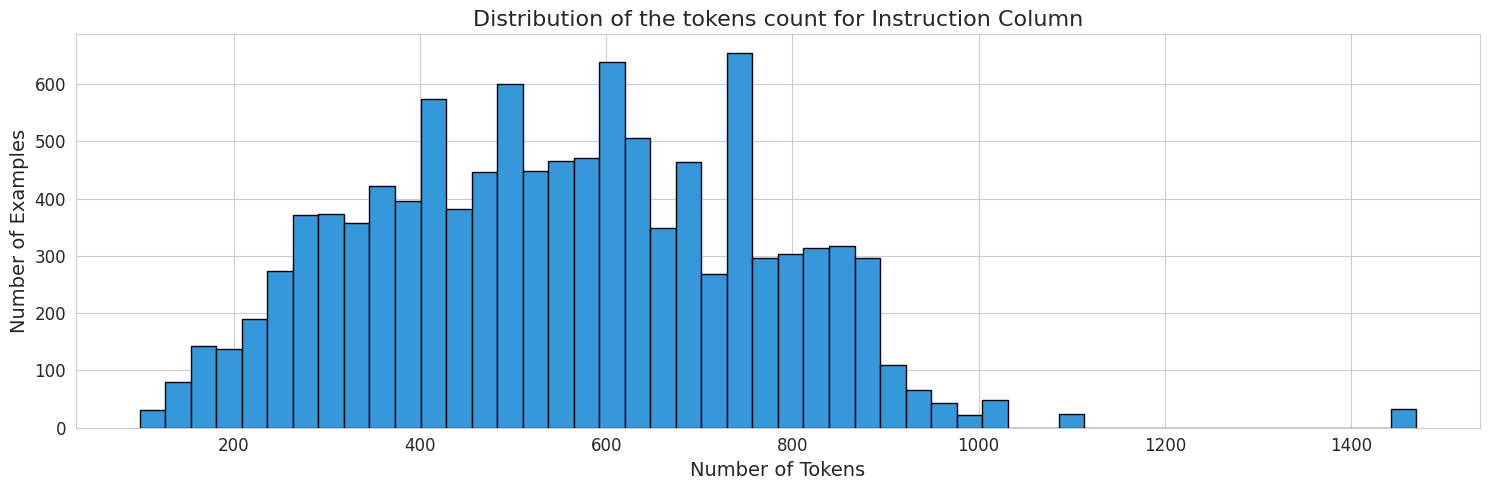

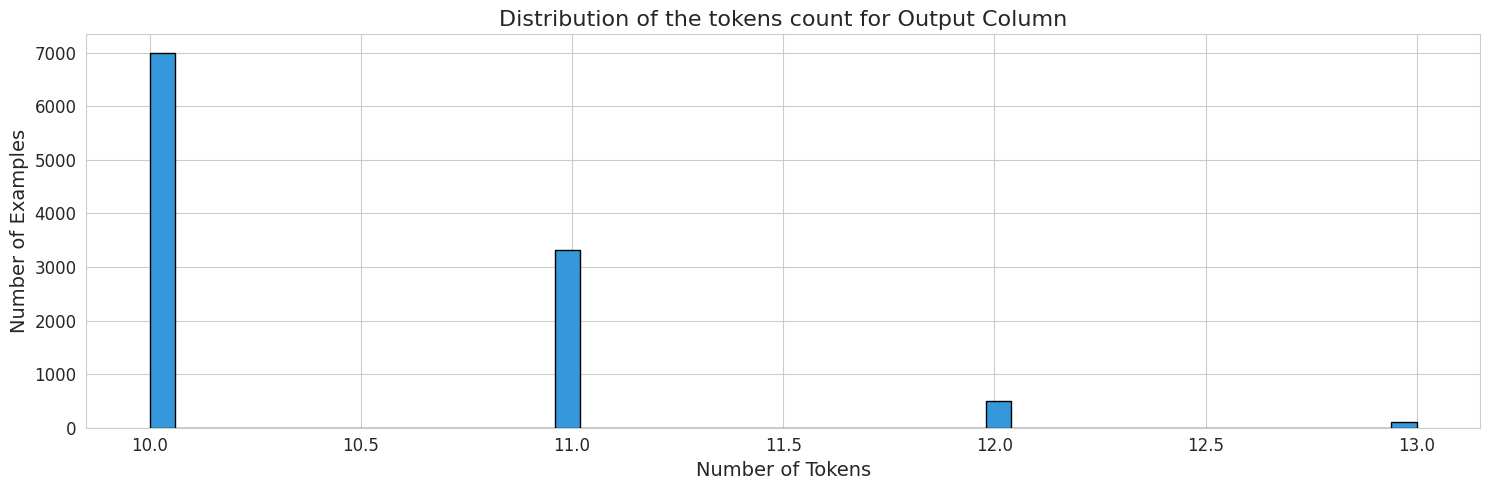

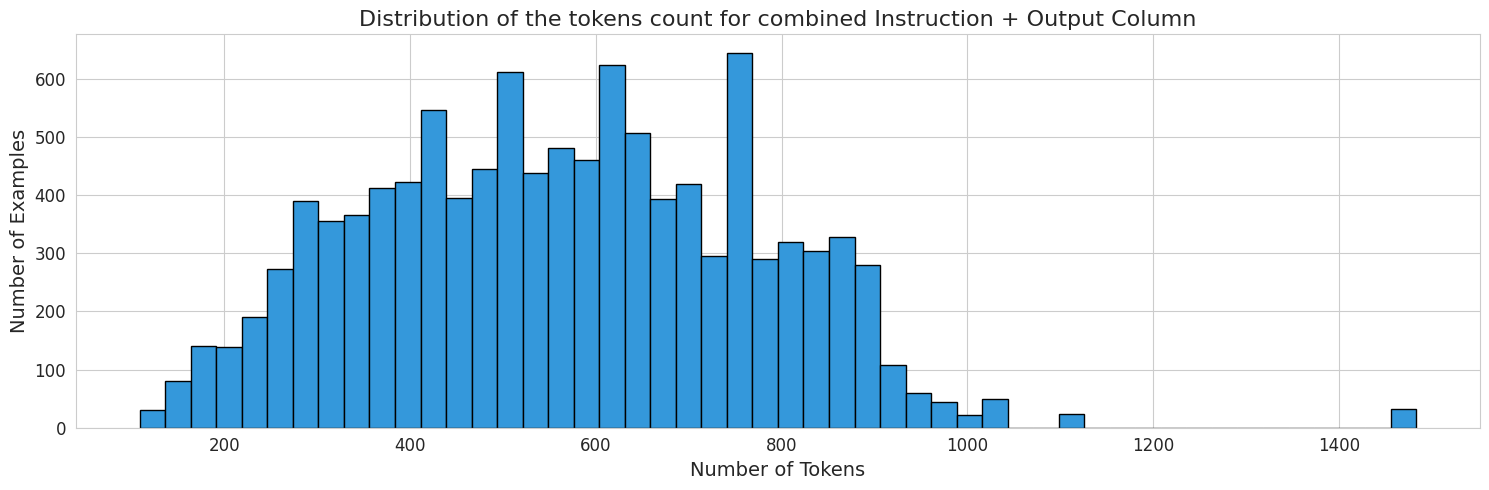

In [ ]:
# Create a histogram using the matplotlib to see the distribution of our token counts
def plot_distribution(tokens_count, title):
  sns.set_style("whitegrid")
  plt.figure(figsize=(15, 5))
  plt.hist(tokens_count, bins=50, color='#3498db', edgecolor='black')
  plt.title(title, fontsize=16)
  plt.xlabel("Number of Tokens", fontsize=14)
  plt.ylabel("Number of Examples", fontsize=14)
  plt.xticks(fontsize=12)
  plt.yticks(fontsize=12)
  plt.tight_layout()
  plt.show()

# Insruction Tokens Count
plot_distribution(instruction_tokens_count, "Distribution of the tokens count for Instruction Column")
# Output Tokens Count
plot_distribution(out_tokens_count, "Distribution of the tokens count for Output Column")
# Combined Tokens Count
plot_distribution(combine_tokens_count, "Distribution of the tokens count for combined Instruction + Output Column")
# The mean is around 600 tokens for combined instruction and output

In [ ]:
model.config.use_cache = False
model.config.pretraining_tp = 1

In [ ]:
# With quantization memory footprint is reduced to nearly 11 Gb from 25 GB for llama 7b
print(f"Memory footprint in bytes: {model.get_memory_footprint()}")

Memory footprint in bytes: 7083970560


In [ ]:
print(json.dumps(model.hf_device_map, indent=4))

{
    "": 0
}


### 4. Training Setup

Using peft library for Parameter Efficient Fine-Tuning

In [ ]:
output_dir="./results"
num_train_epochs=1
per_device_train_batch_size=4
gradient_accumulation_steps=4
optim="paged_adamw_32bit"
save_steps=100
logging_steps=1
learning_rate=2e-3
weight_decay=0.001
fp16=True
bf16=False
max_grad_norm=0.3
max_steps=-1
warmup_ratio=0.03
group_by_length=True
lr_scheduler_type="cosine" #cosine
report_to="wandb"
seed=42
evaluation_strategy="steps"
eval_steps=10

In [ ]:
# wandb config


wandb_config = {
    "speaker":config.speaker,
    "video":config.video,
    "audio":config.audio,
    "lr":learning_rate,
    "epochs":num_train_epochs,
    "llama-model":13,
}

run = wandb.init(project="llm-mecpe", entity='arefa2001', name="13b-speaker", config=wandb_config)

eval/loss,█▁
eval/runtime,▁█
eval/samples_per_second,▁▁
eval/steps_per_second,▁▁
train/epoch,▁▁▁▁▁▁▁▁
train/global_step,▁▂▂▄▅▅▇█
train/learning_rate,▁▂▄▅▇█
train/loss,▅█▂▁▅▆
eval/loss,1.71546
eval/runtime,1246.6513
eval/samples_per_second,1.042


In [ ]:
def print_trainable_parameters(model):
    trainable_params = 0
    all_params = 0
    for _, param in model.named_parameters():
        all_params += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f'Trainable parameters: {trainable_params} | All params: {all_params} | Trainable%: {trainable_params*100.0/all_params}'
    )
model.config.use_cache = False # silence warnings, enable for inferencing

In [ ]:
from peft import prepare_model_for_kbit_training

model.gradient_checkpointing_enable()
model = prepare_model_for_kbit_training(model)

print(model)

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): LlamaForCausalLM(
      (model): LlamaModel(
        (embed_tokens): Embedding(32000, 5120)
        (layers): ModuleList(
          (0-39): 40 x LlamaDecoderLayer(
            (self_attn): LlamaAttention(
              (q_proj): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=5120, out_features=5120, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.1, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=5120, out_features=16, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=16, out_features=5120, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
              )
              (k_proj): lora.Linear4bit(
                (base_layer): Linear4bit(i

In [ ]:
from peft import LoraConfig, get_peft_model

peft_config = LoraConfig(
    lora_alpha=16, # alpha scaling
    lora_dropout=0.1,
    r=16, # attention_heads
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj"],
    bias="none",
    task_type="CAUSAL_LM", # or for seq2seq
)

model = get_peft_model(model, peft_config)
print_trainable_parameters(model)

Trainable parameters: 26214400 | All params: 6698193920 | Trainable%: 0.391365199531279


In [ ]:
# Load training arguments
from transformers import TrainingArguments

training_arguments = TrainingArguments(
    output_dir=output_dir,
    num_train_epochs=num_train_epochs,
    per_device_train_batch_size=per_device_train_batch_size,
    gradient_accumulation_steps=gradient_accumulation_steps,
    optim="paged_adamw_32bit",
    save_steps=save_steps,
    logging_steps=logging_steps,
    learning_rate=learning_rate,
    weight_decay=weight_decay,
    fp16=fp16,
    bf16=False,
    max_grad_norm=max_grad_norm,
    max_steps=max_steps,
    warmup_ratio=warmup_ratio,
    group_by_length=group_by_length,
    lr_scheduler_type=lr_scheduler_type, #cosine
    report_to="wandb",
    seed=config.seed,
    evaluation_strategy="steps",
    eval_steps=eval_steps
)

### 5. Supervised Fine Tuning using SFTTrainer

Using SFTTrainer from TRL library that gives a wrapper around transformers ```Trainer``` to easily fine-tune models on instruction based datasets using PEFT adapters.

In [ ]:
from trl import SFTTrainer

trainer = SFTTrainer(
    model=model,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    dataset_text_field="text",
    # max_seq_length=4096,
    peft_config=peft_config,
    tokenizer=tokenizer,
    args=training_arguments,
)

/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:222: UserWarning: You didn't pass a `max_seq_length` argument to the SFTTrainer, this will default to 1024
  warnings.warn(


Map:   0%|          | 0/10914 [00:00<?, ? examples/s]

Map:   0%|          | 0/1299 [00:00<?, ? examples/s]

In [ ]:
# train for fewer epochs
trainer.train()

/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss,Validation Loss
100,0.656300,0.784557
200,0.524000,0.882381
300,0.490900,1.011410
400,0.479400,1.483532


/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.

KeyboardInterrupt: 

In [ ]:
def save_peft_model(save_folder, speaker=False, video=False, audio=False):
    if speaker and not video and  not audio:
        save_folder = os.path.join(save_folder, "speaker")
    elif speaker and video and not audio:
        save_folder = os.path.join(save_folder, "video")
    elif speaker and audio and not video:
        save_folder = os.path.join(save_folder, "audio")
    elif speaker and audio and video:
        save_folder = os.path.join(save_folder, "audio_video")
    else:
        save_folder = os.path.join(save_folder, "context")
    if not os.path.exists(save_folder):
        os.makedirs(save_folder)
    trainer.save_model(save_folder)
    return save_folder

In [ ]:
peft_model_path="./saved-peft-model"
peft_model_folder = save_peft_model(peft_model_path, config.speaker, config.video, config.audio)

**Pushing to huggingface hub**

In [ ]:
from huggingface_hub import notebook_login

In [ ]:
notebook_login()

In [ ]:
from huggingface_hub import create_repo

In [1]:
# create_repo("ArefaMuzaffar/llama-13b-speaker-emotion", token="hf_your_token_for_write", private=True)

In [ ]:
trainer.push_to_hub("llama-13b-speaker-emotion")

training_args.bin:   0%|          | 0.00/4.54k [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/105M [00:00<?, ?B/s]

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

CommitInfo(commit_url='https://huggingface.co/ArefaMuzaffar/results/commit/2d8bcfd4e5f9712c55c4317fb7ee3cccc0f56bdf', commit_message='llama-13b-speaker-emotion', commit_description='', oid='2d8bcfd4e5f9712c55c4317fb7ee3cccc0f56bdf', pr_url=None, pr_revision=None, pr_num=None)

In [ ]:
!zip -r results2.zip results/

  adding: results/ (stored 0%)
  adding: results/checkpoint-100/ (stored 0%)
  adding: results/checkpoint-100/scheduler.pt (deflated 56%)
  adding: results/checkpoint-100/optimizer.pt (deflated 8%)
  adding: results/checkpoint-100/adapter_model.safetensors (deflated 7%)
  adding: results/checkpoint-100/trainer_state.json (deflated 84%)
  adding: results/checkpoint-100/special_tokens_map.json (deflated 73%)
  adding: results/checkpoint-100/README.md (deflated 66%)
  adding: results/checkpoint-100/adapter_config.json (deflated 52%)
  adding: results/checkpoint-100/tokenizer.json (deflated 74%)
  adding: results/checkpoint-100/tokenizer_config.json (deflated 66%)
  adding: results/checkpoint-100/rng_state.pth (deflated 25%)
  adding: results/checkpoint-100/training_args.bin (deflated 50%)
  adding: results/checkpoint-400/ (stored 0%)
  adding: results/checkpoint-400/scheduler.pt (deflated 56%)
  adding: results/checkpoint-400/optimizer.pt (deflated 9%)
  adding: results/checkpoint-400/ada

### 6. Inference

In [ ]:
model.config.use_cache = True
model.eval()

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): PeftModelForCausalLM(
      (base_model): LoraModel(
        (model): LlamaForCausalLM(
          (model): LlamaModel(
            (embed_tokens): Embedding(32000, 5120)
            (layers): ModuleList(
              (0-39): 40 x LlamaDecoderLayer(
                (self_attn): LlamaAttention(
                  (q_proj): lora.Linear4bit(
                    (base_layer): Linear4bit(in_features=5120, out_features=5120, bias=False)
                    (lora_dropout): ModuleDict(
                      (default): Dropout(p=0.1, inplace=False)
                    )
                    (lora_A): ModuleDict(
                      (default): Linear(in_features=5120, out_features=16, bias=False)
                    )
                    (lora_B): ModuleDict(
                      (default): Linear(in_features=16, out_features=5120, bias=False)
                    )
                    (lora_embedding_A): ParameterDict()
             

In [ ]:
test_dataset[0]["instruction"]

'<s>[INST]\nIdentify the emotion label out of the 7 labels: joy, anger, disgust, fear, sadness, surprise, neutral for utterance 1. No explanation.\nOutput in format:\nutterance_id :: emotion_label\n\n"conversation": [\n{\n"utterance_ID": 1\n"text": Hey !\n"speaker": Joey\n}\n{\n"utterance_ID": 2\n"text": So , what are you guys in the market for ? We have got uh , scarves , tulip post cards ...\n"speaker": The Vendor\n}\n{\n"utterance_ID": 3\n"text": Check this out ? Huh ? Yeah . That is the stuff . What do you think ?\n"speaker": Joey\n}\n{\n"utterance_ID": 4\n"text": Well , I do not have to buy that , " I am with stupid " T ... shirt anymore .\n"speaker": Chandler\n}\n{\n"utterance_ID": 5\n"text": Well , I like it . Here you go .\n"speaker": Joey\n}\n{\n"utterance_ID": 6\n"text": All right , look , you are not really gonna buy that are you ? Do not you think you have embarrassed me enough for one day ?\n"speaker": Chandler\n}\n{\n"utterance_ID": 7\n"text": Oh , I embarrass you ?\n"spe

In [ ]:
print(test_dataset[0]["text"])

<s>[INST]
Identify the emotion label out of the 7 labels: joy, anger, disgust, fear, sadness, surprise, neutral for utterance 1. No explanation.
Output in format:
utterance_id :: emotion_label

"conversation": [
{
"utterance_ID": 1
"text": Hey !
"speaker": Joey
}
{
"utterance_ID": 2
"text": So , what are you guys in the market for ? We have got uh , scarves , tulip post cards ...
"speaker": The Vendor
}
{
"utterance_ID": 3
"text": Check this out ? Huh ? Yeah . That is the stuff . What do you think ?
"speaker": Joey
}
{
"utterance_ID": 4
"text": Well , I do not have to buy that , " I am with stupid " T ... shirt anymore .
"speaker": Chandler
}
{
"utterance_ID": 5
"text": Well , I like it . Here you go .
"speaker": Joey
}
{
"utterance_ID": 6
"text": All right , look , you are not really gonna buy that are you ? Do not you think you have embarrassed me enough for one day ?
"speaker": Chandler
}
{
"utterance_ID": 7
"text": Oh , I embarrass you ?
"speaker": Joey
}
{
"utterance_ID": 8
"text"

In [ ]:
index = 1
prompt = test_dataset[index]["instruction"]
baseline_output = test_dataset[index]["out"]

input_ids = tokenizer(prompt, return_tensors='pt',truncation=True).input_ids.cuda()

outputs = model.generate(input_ids=input_ids, max_new_tokens=512, )
output = tokenizer.batch_decode(outputs.detach().cpu().numpy(), skip_special_tokens=True)[0][len(prompt):]

dash_line = '-'.join('' for x in range(100))
print(dash_line)
print(f'INPUT PROMPT:\n{prompt}')
print(dash_line)
print(f'BASELINE:\n{baseline_output}\n')
print(dash_line)
print(f'TRAINED MODEL GENERATED TEXT :\n{output}')

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


---------------------------------------------------------------------------------------------------
INPUT PROMPT:
<s>[INST]
Identify the emotion label out of the 7 labels: joy, anger, disgust, fear, sadness, surprise, neutral for utterance 1. No explanation.
Output in format:
utterance_id :: emotion_label

"conversation": [
{
"utterance_ID": 1
"text": Hey !
"speaker": Joey
}
{
"utterance_ID": 2
"text": So , what are you guys in the market for ? We have got uh , scarves , tulip post cards ...
"speaker": The Vendor
}
{
"utterance_ID": 3
"text": Check this out ? Huh ? Yeah . That is the stuff . What do you think ?
"speaker": Joey
}
{
"utterance_ID": 4
"text": Well , I do not have to buy that , " I am with stupid " T ... shirt anymore .
"speaker": Chandler
}
{
"utterance_ID": 5
"text": Well , I like it . Here you go .
"speaker": Joey
}
{
"utterance_ID": 6
"text": All right , look , you are not really gonna buy that are you ? Do not you think you have embarrassed me enough for one day ?
"sp

In [ ]:
index = 3
prompt = test_dataset[index]["instruction"]
baseline_output = test_dataset[index]["out"]

input_ids = tokenizer(prompt, return_tensors='pt',truncation=True).input_ids.cuda()

outputs = model.generate(input_ids=input_ids, max_new_tokens=512, )
output = tokenizer.batch_decode(outputs.detach().cpu().numpy(), skip_special_tokens=True)[0]

dash_line = '-'.join('' for x in range(100))
print(dash_line)
print(f'INPUT PROMPT:\n{prompt}')
print(dash_line)
print(f'BASELINE:\n{baseline_output}\n')
print(dash_line)
print(f'TRAINED MODEL GENERATED TEXT :\n{output}')

---------------------------------------------------------------------------------------------------
INPUT PROMPT:
<s>[INST]
Identify the emotion label out of the 7 labels: joy, anger, disgust, fear, sadness, surprise, neutral for utterance 4. No explanation.
Output in format:
utterance_id :: emotion_label

"conversation": [
{
"utterance_ID": 1
"text": Hey !
"speaker": Joey
}
{
"utterance_ID": 2
"text": So , what are you guys in the market for ? We have got uh , scarves , tulip post cards ...
"speaker": The Vendor
}
{
"utterance_ID": 3
"text": Check this out ? Huh ? Yeah . That is the stuff . What do you think ?
"speaker": Joey
}
{
"utterance_ID": 4
"text": Well , I do not have to buy that , " I am with stupid " T ... shirt anymore .
"speaker": Chandler
}
{
"utterance_ID": 5
"text": Well , I like it . Here you go .
"speaker": Joey
}
{
"utterance_ID": 6
"text": All right , look , you are not really gonna buy that are you ? Do not you think you have embarrassed me enough for one day ?
"sp

### 7. Push model to hub

In [ ]:
# Merge LoRA and base model
merged_model = model.merge_and_unload()

# Save the merged model
merged_model.save_pretrained("ArefaMuzaffar/merged-llama-speaker-emotion",safe_serialization=True)
tokenizer.save_pretrained("ArefaMuzaffar/merged-llama-speaker-emotion")

/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/bnb.py:229: UserWarning: Merge lora module to 4-bit linear may get different generations due to rounding errors.
  warnings.warn(


('merged-llama-speaker-emotion/tokenizer_config.json',
 'merged-llama-speaker-emotion/special_tokens_map.json',
 'merged-llama-speaker-emotion/tokenizer.json')

In [ ]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

In [ ]:
!pip install huggingface_hub

In [ ]:
from huggingface_hub import upload_folder

In [ ]:
upload_folder(repo_id="ArefaMuzaffar/merged-llama-13b-speaker-emotion", folder_path="merged-llama-speaker-emotion")

adapter_model.safetensors:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/ArefaMuzaffar/merged-llama-13b-speaker-emotion/commit/8103fa0f225df12603307cefe71614c8ecebc4dd', commit_message='Upload folder using huggingface_hub', commit_description='', oid='8103fa0f225df12603307cefe71614c8ecebc4dd', pr_url=None, pr_revision=None, pr_num=None)

### 7. Evaluation on Test Data

In [ ]:
import string

uppercase_set = set(string.ascii_uppercase)
lowercase_set = set(string.ascii_lowercase)
chars = uppercase_set.union(lowercase_set)

In [ ]:
def extract_emotion_label(pred_label):
    """pred_label is raw output string from the model
    Like ["utterance_id :: anger ...", "2 :: fear ...", ]
    It could be inconsistent
    """
    label = pred_label.split("::")[1]
    label = label.strip()
    out_label = ""
    for c in label:
        if c not in chars:
            break
        out_label += c
    return out_label.strip()

In [ ]:
def get_full_output(prompt):
    input_ids = tokenizer(prompt, return_tensors='pt',truncation=True).input_ids.cuda()

    outputs = model.generate(input_ids=input_ids, max_new_tokens=1024, )
    output = tokenizer.batch_decode(outputs.detach().cpu().numpy(), skip_special_tokens=True)[0]
    return output

In [ ]:
def infer_emotion(dataset):
    pred_labels_list = []
    true_labels_list = []
    for i in range(len(dataset)):
        if i == 1:
            break
        # predict
        prompt = dataset[i]["instruction"]
        output = get_full_output(prompt)
        output = output.split("utterance_id :: emotion_label")[1]
        output = extract_emotion_label(output.strip())
        output = output.strip().lower()
        print("Predicted Output: ", output.strip().lower())
        pred_labels_list.append(output)
        # baseline
        baseline_output = dataset[i]["out"]
        baseline_output = extract_emotion_label(baseline_output.strip())
        print("Baseline: ", baseline_output.strip().lower())
        baseline_output = baseline_output.strip().lower()
        true_labels_list.append(baseline_output)
        if output == baseline_output:
            print("Correct")
        else:
            print("Incorrect")
    return pred_labels_list, true_labels_list

In [ ]:
infer_emotion(test_dataset)

Predicted Output:  joy
Baseline:  joy
Correct


(['joy'], ['joy'])

In [ ]:
def evaluate_emotion_labels(pred_labels_list, true_labels_list):
